### DEPOSITE DETECTION MODEL FOR BANK MARKETING CAMPAIGN

#### Import Relevant Pakages

In [1]:
#!pip install imblearn --user
#!pip install xgboost --user

#!pip install mlxtend


In [2]:
#from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, roc_auc_score

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV




%matplotlib inline

sns.set()

#### Import dataset

In [3]:
bank = pd.read_csv('bank.csv', sep = ';',engine = 'python')#, nrows = 100

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

# changing figure size


In [4]:
#shape of dataset
nRow, nCol = bank.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 4521 rows and 17 columns


In [5]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [6]:
bank.rename(columns={'y': 'deposit'}, inplace=True)

In [7]:
# display first 5 rows
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


#### Metadata

##### Getting to know the meaning of the columns

<!-- #### age (numeric)
###### job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",                                       "blue-collar","self-employed","retired","technician","services") 
###### marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
###### education (categorical: "unknown","secondary","primary","tertiary")
###### : has credit in default? (binary: "yes","no")
###### balance: average yearly balance, in euros (numeric) 
###### housing: has housing loan? (binary: "yes","no")
###### loan: has personal loan? (binary: "yes","no")
   ###### related with the last contact of the current campaign:
###### contact: contact communication type (categorical: "unknown","telephone","cellular") 
###### day: last contact day of the month (numeric)
###### month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
###### duration: last contact duration, in seconds (numeric)
   ######  other attributes:
###### campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
###### pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
###### previous: number of contacts performed before this campaign and for this client (numeric)
###### poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

######   Output variable (desired target):
###### deposite - has the client subscribed a term deposit? (binary: "yes","no") -->

#### Exploratory Data Analysis

#### Descriptive statistic

Note:

- Confirming thier are no null and duplicate values in the dataset

In [8]:
pd.isnull(bank).sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [9]:
bank = bank.dropna(how='all')

In [10]:
duplicate = bank[bank.duplicated()]
#bank.drop_duplicates(inplace=True)
duplicate

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit


In [11]:
bank.describe(include = 'object').transpose()

,count,unique,top,freq
job,4521,12,management,969
marital,4521,3,married,2797
education,4521,4,secondary,2306
default,4521,2,no,4445
housing,4521,2,yes,2559
loan,4521,2,no,3830
contact,4521,3,cellular,2896
month,4521,12,may,1398
poutcome,4521,4,unknown,3705
deposit,4521,2,no,4000


In [12]:
print(bank.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  deposit    4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 635.8+ KB
None


#### Numerical data summary

In [13]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


Note:

*  There are outliers in the following columns: balance, duration, campaign, pdays, previous.

*  Let's plot these columns with boxplot to visualize the outliers.

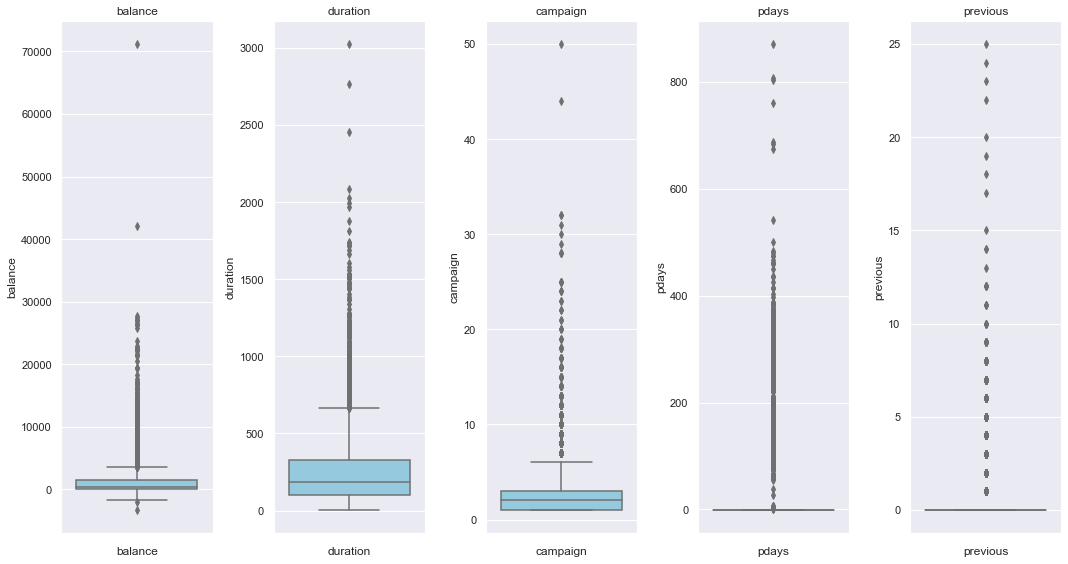

In [14]:
outlier_columns = ['balance', 'duration', 'campaign', 'pdays', 'previous']

plt.figure(figsize=(15, 8))

# Create box plots for each column
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(1, len(outlier_columns), i)
    sns.boxplot(y=bank[col], color='skyblue')
    plt.title(f'{col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

Note

*  Finding out the outliers percentages in the data

In [15]:
outliers_perc = []

for k,v in bank.items():
    # Column must be of numeric type (not object)
    if bank[k].dtype != 'O':
        Q1 = v.quantile(0.25)
        Q3 = v.quantile(0.75)
        irq = Q3 - Q1
        v_col = v[(v <= Q1 - 1.5 * irq) | (v >= Q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(bank)[0]
        out_tuple = (k,int(perc))
        outliers_perc.append(out_tuple)
        print("Column %s outliers = %.2f%%" % (k,perc))

Column age outliers = 0.97%
Column balance outliers = 11.19%
Column day outliers = 0.00%
Column duration outliers = 7.30%
Column campaign outliers = 10.46%
Column pdays outliers = 100.00%
Column previous outliers = 100.00%


Note

IQR rule which will be used in removing the outliers.

- Formula for lower boundary -> Q1 - 1.5 * IQR
- Formula for UPPER boundary -> Q1 + 1.5 * IQR

The data between these boundaries are acceptable.

In [16]:
outlier_columns = ['balance', 'duration', 'campaign', 'pdays', 'previous']

Q1 = bank[outlier_columns].quantile(0.15)
Q3 = bank[outlier_columns].quantile(0.85)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

bank = bank[~((bank[outlier_columns] < lower_bound) | (bank[outlier_columns] > upper_bound)).any(axis=1)]

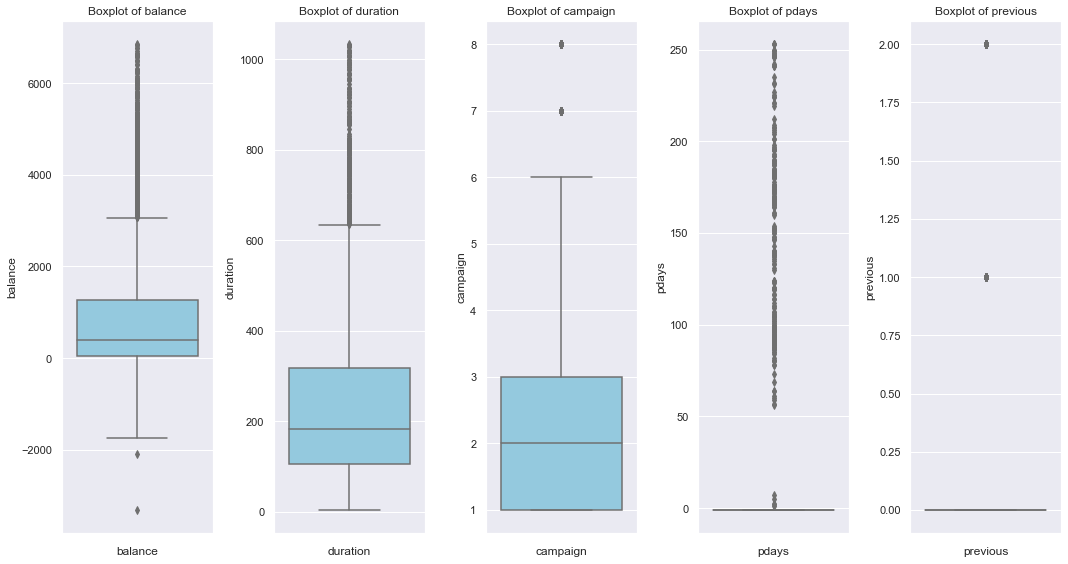

In [17]:
plt.figure(figsize=(15, 8))

# Create box plots for each column
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(1, len(outlier_columns), i)
    sns.boxplot(y=bank[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

### Categorical Variables

#### Distribution of Categorical Variables

In [18]:
categorical_cols = bank.select_dtypes(include='object').columns.tolist()
print("Categorical Columns:", categorical_cols)

Categorical Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


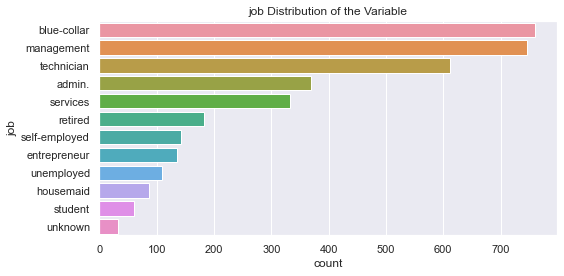

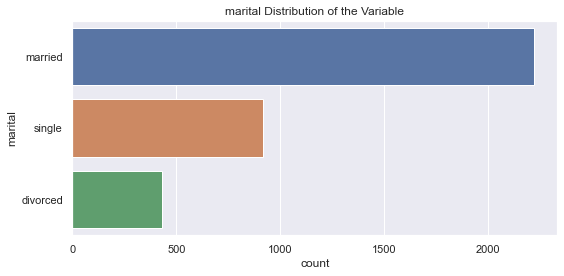

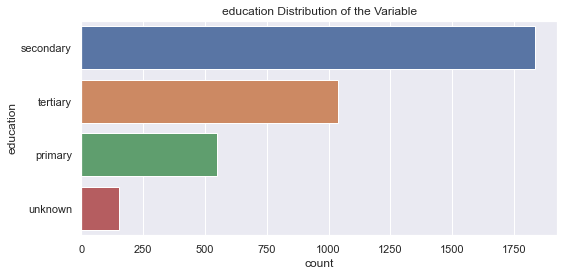

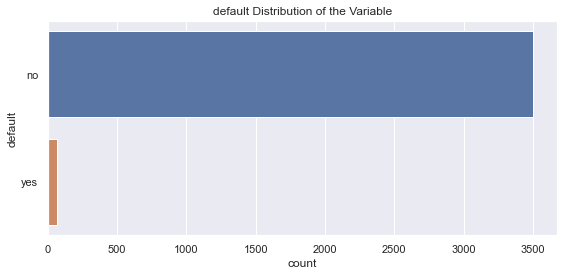

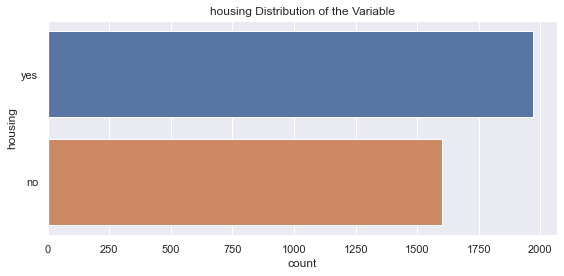

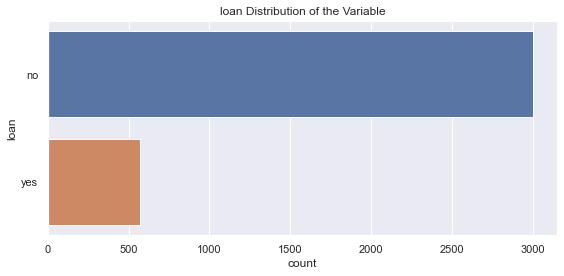

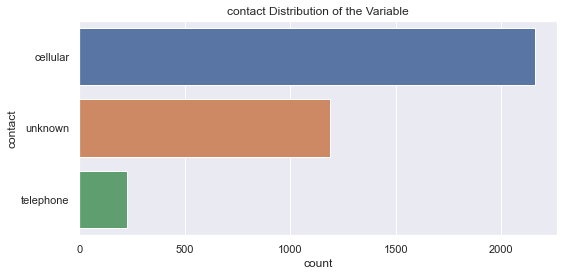

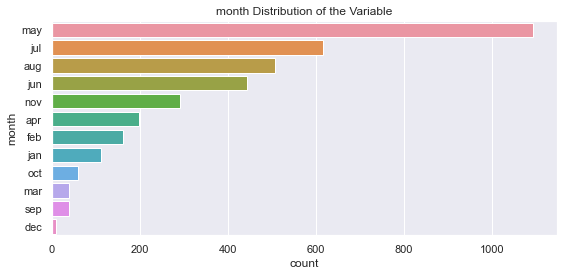

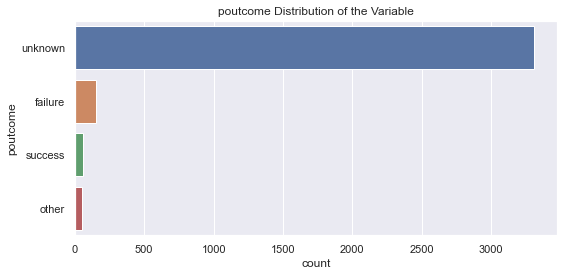

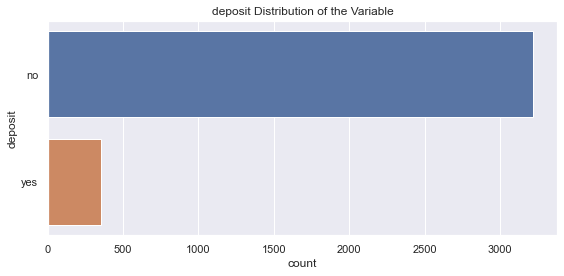

In [19]:
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=col, data=bank, order=bank[col].value_counts().index)
    plt.title(f'{col} Distribution of the Variable')
    plt.tight_layout()
    plt.show()

#### Investigating the ratio of Categorical Variables in relation to deposit

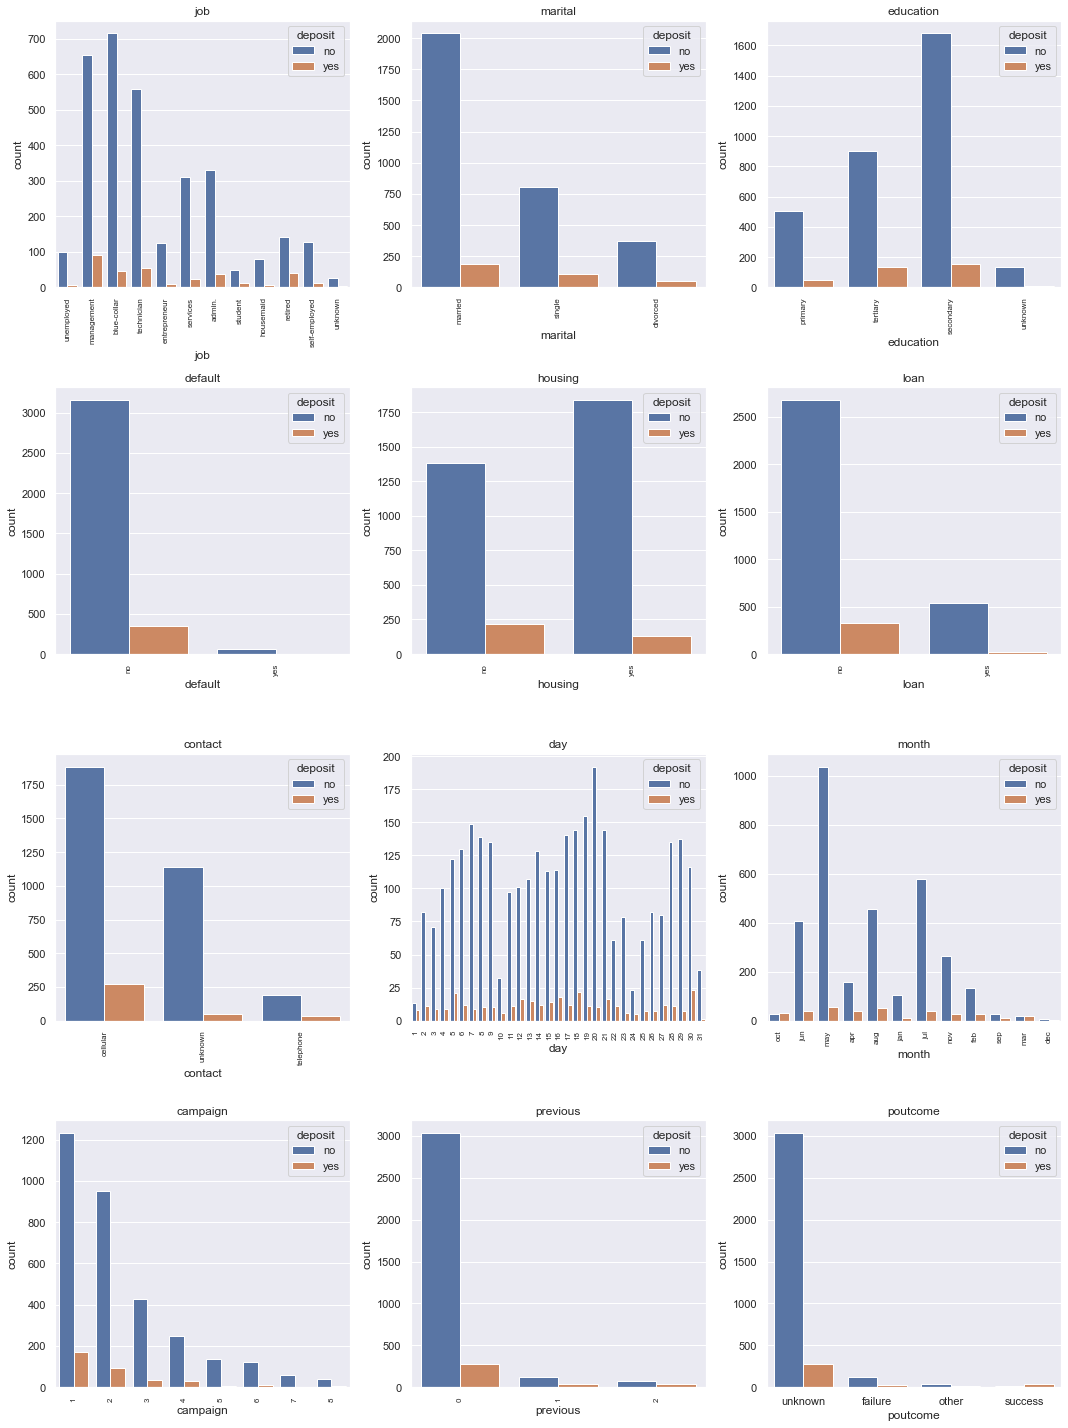

In [20]:
dataset_variables =['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'day', 'month',  'campaign',
       'previous', 'poutcome']  #'duration',

num_vars = len(dataset_variables)

cols = 3  
rows = (num_vars + cols - 1) // cols  

plt.figure(figsize=(5 * cols, 5 * rows))

for i, var in enumerate(dataset_variables):
    plt.xticks(rotation=90, fontsize=8)
    plt.subplot(rows, cols, i + 1) 
    sns.countplot(data=bank, x=var, hue='deposit')  
    plt.title(var) 
    
plt.tight_layout() 
plt.show()

In [21]:
#From the pair plot above

In [22]:
# 'age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
#        'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
#        'previous', 'poutcome

In [23]:
bank["deposit"].value_counts()

no     3219
yes     352
Name: deposit, dtype: int64

In [24]:
# The data is highly imbalanced, this issue will be resolved with the help of the SMOTE techique

In [25]:
pd.crosstab(index=bank['housing'], columns=bank['deposit'])

deposit,no,yes
housing,,
no,1382,219
yes,1837,133


The first plot shows that there is a higher probability of a success whenever the targeted client does not have a housing loan.

In [26]:
pd.crosstab(index=bank['loan'], columns=bank['deposit'])

deposit,no,yes
loan,,
no,2676,326
yes,543,26


The second plot shows that a client with a loan would not usually open a term deposit.

In [27]:
pd.crosstab(index=bank['month'], columns=bank['deposit'])

deposit,no,yes
month,,
apr,158,41
aug,455,51
dec,6,4
feb,135,28
jan,103,10
jul,577,38
jun,406,38
mar,21,18
may,1037,56


The plot shows that May is the month with the most attempts by the marketing company. It is also a month when the success to unsuccess ratio is very low. On the contrary, there are months, like March, September or October, when the success to unsuccess ratio is pretty high.
Maybe the company should shift its main effort from late spring and summer months towards autumn and winter months.

In [28]:
pd.crosstab(index=bank['marital'], columns=bank['deposit'])

deposit,no,yes
marital,,
divorced,375,54
married,2037,186
single,807,112


In [29]:
pd.crosstab(index=bank['education'], columns=bank['deposit'])

deposit,no,yes
education,,
primary,502,48
secondary,1678,156
tertiary,902,135
unknown,137,13


In [30]:
pd.crosstab(index=bank['default'], columns=bank['deposit'])

deposit,no,yes
default,,
no,3156,345
yes,63,7


In [31]:
pd.crosstab(index=bank['previous'], columns=bank['deposit'])

deposit,no,yes
previous,,
0,3032,280
1,118,35
2,69,37


- The data suggets numerus calls to a person does not result in a deposit  

In [32]:
pd.crosstab(index=bank['poutcome'], columns=bank['deposit'])

deposit,no,yes
poutcome,,
failure,126,23
other,42,10
success,19,39
unknown,3032,280


In [33]:
print(f'Probability of success = {83 / (83 + 46) * 100:.0f}%')
print(f'Probability of failure   = {63 / (63 + 427) * 100:.0f}%')

Probability of success = 64%
Probability of failure   = 13%


 Probability of sucess is higher when the person has in the past made a deposit

In [34]:
pd.crosstab(index=bank['contact'], columns=bank['deposit'])

deposit,no,yes
contact,,
cellular,1885,273
telephone,193,33
unknown,1141,46


Calling the client on the mobile phone gives a slightly higher probability of success.

In [35]:
print(f'Probability of success on landline = {33 / (33 + 193) * 100:.0f}%')
print(f'Probability of success on mobile   = {273 / (273 + 1885) * 100:.0f}%')

Probability of success on landline = 15%
Probability of success on mobile   = 13%


The difference is rather small and might not be statistically significant. This is worth to check.

#### Summary

It is worth to note that:

- The majority of clients work as administrators, in the services or as blue collar.
- The majority of clients are married.
- They mainly communicate with the marketing staff via cellular.
- The majority of them has either secondary (high school) or tertiary (college) education.
- The large majority of clients do not have credits on default and are not on a loan either.

#### Distribution of Numerical Variables

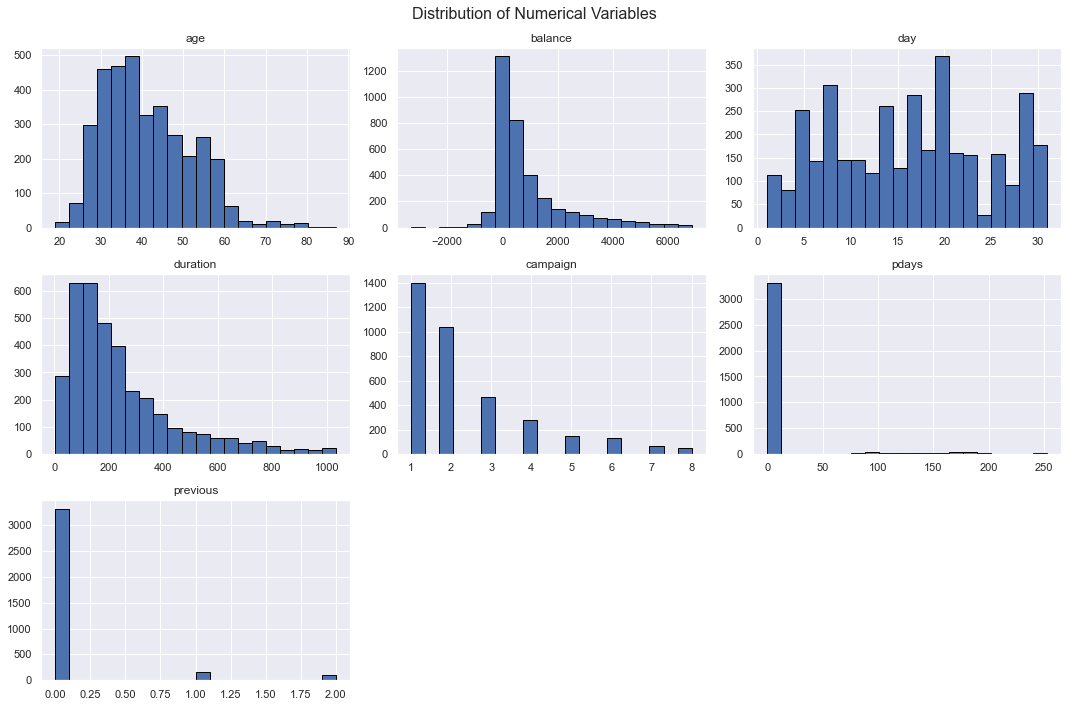

In [36]:
numeric_cols = bank.select_dtypes(include=['int64', 'float64']).columns.tolist()


bank[numeric_cols].hist(bins=20, figsize=(15, 10), edgecolor='black')
plt.suptitle("Distribution of Numerical Variables", fontsize=16)
plt.tight_layout()
plt.show()

Note:

- None of the distributions is bell-shaped.
- The age and day distributions are more spread than the others. The first is (almost) single-peaked and right-skewed, while the second is multi-peaked (with 3 main peaks).
- The remaining numerical distributions have a high peak around the origin, meaning that the higher values are less frequent than small ones.

### Performing cluster analysis to identify some patterns

In [37]:
#Clustering age groups

bank.loc[bank['age'] <= 25, 'age cluster'] = 'age <= 25'
bank.loc[(bank['age'] > 25) & (bank['age'] <= 35), 'age cluster'] = '25 < age <= 35'
bank.loc[(bank['age'] > 35) & (bank['age'] <= 45), 'age cluster'] = '35 < age <= 45'
bank.loc[(bank['age'] > 45) & (bank['age'] <= 55), 'age cluster'] = '45 < age <= 55'
bank.loc[(bank['age'] > 55) & (bank['age'] <= 65), 'age cluster'] = '55 < age <= 65'
bank.loc[bank['age'] > 65, 'age cluster'] = 'age > 65'

In [38]:
age_balance_groups = bank.groupby('age cluster',as_index=False)['balance'].median().sort_values(by=['balance'],ascending=False)

In [39]:
#Grouping default, housing and loan columns to make plots

default_yes = bank[bank['default'] == 'yes'].groupby('age cluster')['default'].value_counts().reset_index(name='count yes')

default_no = bank[bank['default'] == 'no'].groupby('age cluster')['default'].value_counts().reset_index(name='count no')

default_yes_perc = default_yes.merge(default_no,on='age cluster')

default_yes_perc['default percentage'] = (default_yes_perc['count yes'] / (default_yes_perc['count yes'] + default_yes_perc['count no'])) * 100

default_yes_perc.drop(['default_x','default_y','count yes','count no'],axis=1,inplace=True)

default_yes_perc = default_yes_perc.sort_values(by='default percentage',ascending=False)


loan_yes = bank[bank['loan'] == 'yes'].groupby('age cluster')['loan'].value_counts().reset_index(name='count yes')

loan_no = bank[bank['loan'] == 'no'].groupby('age cluster')['loan'].value_counts().reset_index(name='count no')

loan_yes_perc = loan_yes.merge(loan_no,on='age cluster')

loan_yes_perc['loan percentage'] = loan_yes_perc['count yes'] / (loan_yes_perc['count yes'] + loan_yes_perc['count no']) * 100

loan_yes_perc.drop(['loan_x','loan_y','count yes','count no'],axis=1,inplace=True)

loan_yes_perc = loan_yes_perc.sort_values(by='loan percentage',ascending=False)

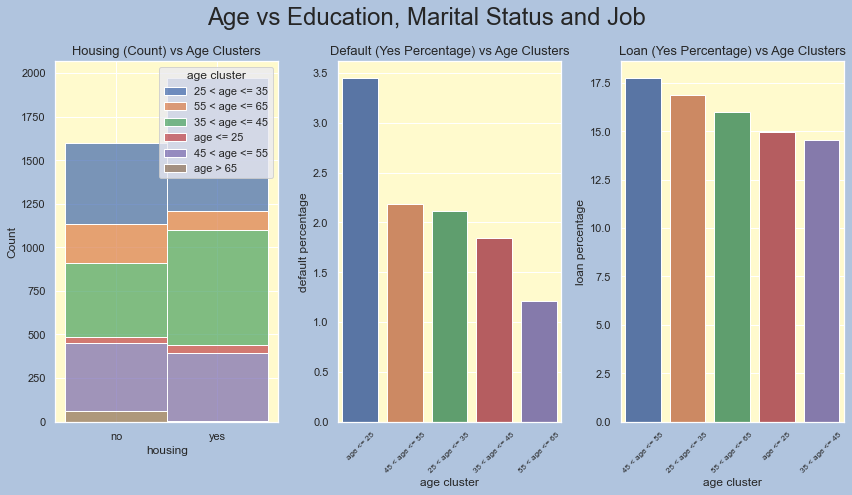

In [40]:
pd.set_option('display.max_columns',None)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,7))

ax1 = sns.histplot(data=bank,x='housing',multiple='stack',hue='age cluster',ax=ax1)
ax1.set_title('Housing (Count) vs Age Clusters',fontsize=13)
ax1.set_facecolor('lemonchiffon')

ax2 = sns.barplot(data=default_yes_perc,x='age cluster',y='default percentage',ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45,fontsize=8)
ax2.set_title('Default (Yes Percentage) vs Age Clusters',fontsize=13)
ax2.set_facecolor('lemonchiffon')

ax3 = sns.barplot(data=loan_yes_perc,x='age cluster',y='loan percentage',ax=ax3)
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=45,fontsize=8)
ax3.set_title('Loan (Yes Percentage) vs Age Clusters',fontsize=13)
ax3.set_facecolor('lemonchiffon')

fig.suptitle("Age vs Education, Marital Status and Job",fontsize=24) 

plt.tight_layout()
fig.set_facecolor('lightsteelblue')

Note:

- A slight majority of clients does not have a housing loan. The fractions of housing_loan = yes and housing_loan = no clients vary depending on their age group: people older than 65 generally do not have a loan, clients belonging to other categories (e.g. those younger than 25) have a loan.

- The percentage of clients with credits in default is relatively small (less than 2%). This default percentage has a large variability within the age groups: clients between 35 and 45 years old have the highest default percentage, old clients (> 65 years) have the smallest.

- The percentage of clients having a loan changes a lot depending on their age group. Almost 16% of clients with 45 < age < 55 have a loan, while less than 1% of clients older than 65 have one.

# Key Take Away

- The longer we talk with the customer on the phone, the higher the chances for them to deposit
- If the previous campaign was successful, the customer is more likely to deposit¶
- If Customer Value Score is high, the customer is more likely to deposit

In [41]:
bank.drop(['age cluster'],axis=1,inplace=True)

#bank.drop(['education','marital','age cluster'],axis=1,inplace=True)

Note:

The feature importance calculation does not work with categorical data, as a result categorical variables will be encoded.
Even though (in a later stage) I will perform the binary classification by one-hot-encoding the categorical columns, here I am using label encoding because (for this task) I do not want to split categorical columns into their single components.

In [42]:
data_feature = bank.copy()

LABELS  = data_feature.columns
encoder = LabelEncoder()

for col in LABELS:
    
    if data_feature[col].dtype == 'O':
        
        data_feature[col] = encoder.fit_transform(data_feature[col])  

X = data_feature.drop('deposit',axis=1)
y = data_feature['deposit']


random_forest = RandomForestClassifier(random_state=1,max_depth=100)
random_forest.fit(X,y)

importances = pd.DataFrame({'feature':X.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)

importances

,feature,importance
11,duration,0.273
0,age,0.122
5,balance,0.119
9,day,0.101
10,month,0.089
1,job,0.054
12,campaign,0.040
3,education,0.034
13,pdays,0.031
2,marital,0.029


Note:

- 'duration' is expected to be (by far) the most important predictor.
- Then we have second-tier features (like 'balance', 'month', 'day' and 'age') and third-tier ones (like 'contact' and 'poutcome').
- The features 'default' or 'loan' are not expected to be so important in predicting the outcome of the marketing campaign.

#### Correlation heatmap

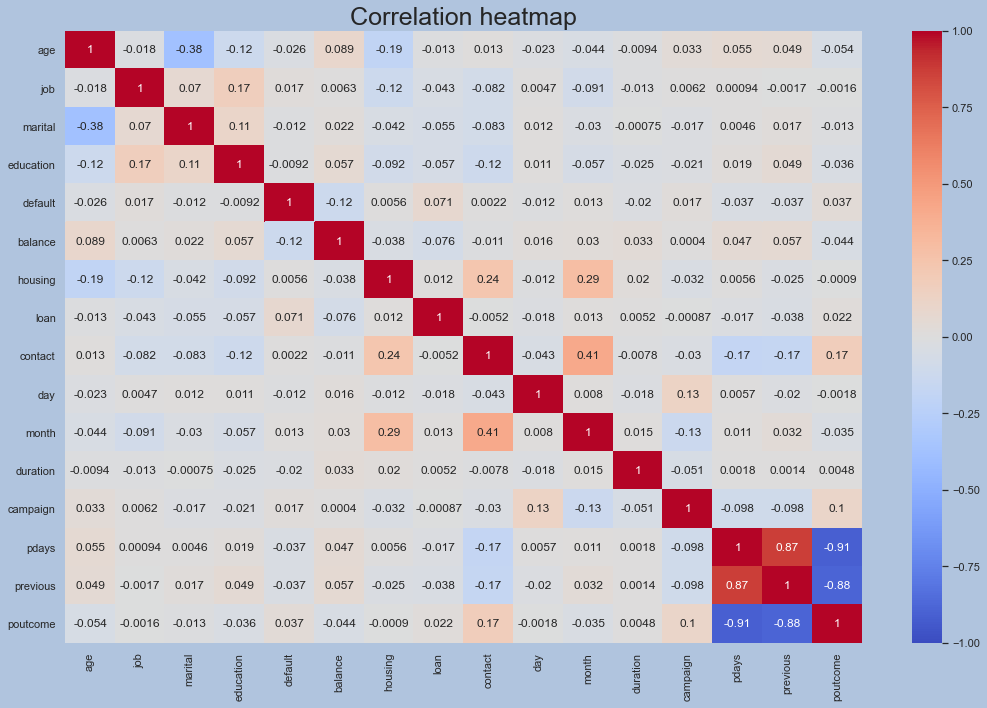

In [43]:
plt.figure(figsize=(15,10))

sns.heatmap(X.corr(method='pearson'),vmin=-1,vmax=1,annot=True,cmap='coolwarm')
plt.title('Correlation heatmap',fontsize=25)

plt.tight_layout()
plt.gcf().patch.set_facecolor('lightsteelblue')
plt.show()

Note:

- There are some variables that are strongly correlated with each another: 'pdays' vs 'poutcome', 'previous' vs 'poutcome', with Pearson coefficient > 0.87.

- Althoug most features are not highly corralated, thier is still the need to investigate by performing a Variance inflation factor to find out whether there is multi-collinearity between them.


In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X[['age', 'job', 'default', 'balance', 'housing', 'loan', 'contact', 'day',
       'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']]

In [45]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['feature'] = variables.columns

In [46]:
vif

,VIF,feature
0,15.332580,age
1,2.845986,job
2,1.041659,default
3,1.503390,balance
4,2.588827,housing
5,1.204989,loan
6,2.090471,contact
7,4.718875,day
8,5.869616,month
9,2.482000,duration


It is best pratise to do way with VIF values above 5 if most of the VIF values are below 5

oldBalanceOrig & newBalanceOrig are highly povitivly corrrelated so one of them will have to be eliminated
oldBalanceDest & newBalanceDest is also positive correlation so one of them will have to be eliminated   
the VIF value for thresholdOrig is also above 5 and should be eliminated

In [47]:
bank.drop(['pdays'],axis=1,inplace=True)

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X[['age', 'job', 'default', 'balance', 'housing', 'loan', 'contact', 'day',
       'month', 'duration', 'campaign', 'poutcome', 'previous']]

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['feature'] = variables.columns

vif

,VIF,feature
0,14.427988,age
1,2.822436,job
2,1.041658,default
3,1.503247,balance
4,2.532096,housing
5,1.201030,loan
6,2.085481,contact
7,4.635826,day
8,5.861148,month
9,2.472694,duration


After eleminating the pdays feature from the dataset, the VIF values appears to be in normal range, all the VIF values are below 5 with the exception of poutcome which is 9 but will not be eliminated as from the preminary analysis reveals that it is signinicant to determining weather persons deposit

### Preprocessing

In [49]:
# replacing yes and no from deposit,default,loan,and housing columns by 1 and 0 to convert categorical feature to numerical feature

bank['deposit'] = bank['deposit'].astype(object).replace(to_replace="yes", value="1").astype("category")
bank['deposit'] = bank['deposit'].astype(object).replace(to_replace="no", value="0").astype("category")
bank['default'] = bank['default'].astype(object).replace(to_replace="yes", value="1").astype("category")
bank['default'] = bank['default'].astype(object).replace(to_replace="no", value="0").astype("category")
bank['loan'] = bank['loan'].astype(object).replace(to_replace="yes", value="1").astype("category")
bank['loan'] = bank['loan'].astype(object).replace(to_replace="no", value="0").astype("category")
bank['housing'] = bank['housing'].astype(object).replace(to_replace="yes", value="1").astype("category")
bank['housing'] = bank['housing'].astype(object).replace(to_replace="no", value="0").astype("category")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,deposit
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,0,unknown,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,0,unknown,0
7,39,technician,married,secondary,0,147,1,0,cellular,6,may,151,2,0,unknown,0
8,41,entrepreneur,married,tertiary,0,221,1,0,unknown,14,may,57,2,0,unknown,0


In [50]:
# one hot encoding for marital feature to convert categorical feature to numerical feature
# dropping original column
# dropping one of the resultant columns


#### Encode Categorical Value

##### Same as the numerical data, we also need to pre-process our categorical data from words to number to make it easier for the computer to understands. To do this we will use OneHotEncoder() provided by sklearn. Basically it will transform a categorical column from this:

In [51]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
cat_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

# Encode Categorical Data
df_encoded = pd.DataFrame(encoder.fit_transform(bank[cat_cols]))
df_encoded.columns = encoder.get_feature_names_out(cat_cols)



# Replace Categotical Data with Encoded Data
bank = bank.drop(cat_cols ,axis=1)
bank = pd.concat([df_encoded, bank], axis=1)

print('Shape of dataframe:', bank.shape)
bank.head()

Shape of dataframe: (4328, 48)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age,default,balance,housing,loan,day,duration,campaign,previous,deposit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,30.0,0,1787.0,0,0,19.0,79.0,1.0,0.0,0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0,1476.0,1,1,3.0,199.0,4.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,59.0,0,0.0,1,0,5.0,226.0,1.0,0.0,0


In [52]:
bank.columns

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'age',
       'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign',
       'previous', 'deposit'],
      dtype='object')

##### dropping one of the resultant columns. This colums are eliminated becasue one can not make a concrate decision based on them

In [53]:
bank = bank.drop('marital_divorced',axis = 1)

bank = bank.drop('poutcome_unknown',axis = 1)

bank = bank.drop('job_unknown',axis = 1)
                 
bank = bank.drop('contact_unknown',axis = 1)

In [54]:
bank.columns

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'age', 'default', 'balance',
       'housing', 'loan', 'day', 'duration', 'campaign', 'previous',
       'deposit'],
      dtype='object')

In [55]:
print(bank.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4328 entries, 0 to 4517
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   job_admin.           3571 non-null   float64 
 1   job_blue-collar      3571 non-null   float64 
 2   job_entrepreneur     3571 non-null   float64 
 3   job_housemaid        3571 non-null   float64 
 4   job_management       3571 non-null   float64 
 5   job_retired          3571 non-null   float64 
 6   job_self-employed    3571 non-null   float64 
 7   job_services         3571 non-null   float64 
 8   job_student          3571 non-null   float64 
 9   job_technician       3571 non-null   float64 
 10  job_unemployed       3571 non-null   float64 
 11  marital_married      3571 non-null   float64 
 12  marital_single       3571 non-null   float64 
 13  education_primary    3571 non-null   float64 
 14  education_secondary  3571 non-null   float64 
 15  education_tertiary   

In [56]:
bank['default'] = bank['default'].astype(np.float).astype("float64")
bank['housing'] = bank['housing'].astype(np.float).astype("float64")
bank['loan'] = bank['loan'].astype(np.float).astype("float64")
bank['deposit'] = bank['deposit'].astype(np.float).astype("float64")



#df['column_name'].astype(np.float).astype("Int32")

print(bank.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4328 entries, 0 to 4517
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_admin.           3571 non-null   float64
 1   job_blue-collar      3571 non-null   float64
 2   job_entrepreneur     3571 non-null   float64
 3   job_housemaid        3571 non-null   float64
 4   job_management       3571 non-null   float64
 5   job_retired          3571 non-null   float64
 6   job_self-employed    3571 non-null   float64
 7   job_services         3571 non-null   float64
 8   job_student          3571 non-null   float64
 9   job_technician       3571 non-null   float64
 10  job_unemployed       3571 non-null   float64
 11  marital_married      3571 non-null   float64
 12  marital_single       3571 non-null   float64
 13  education_primary    3571 non-null   float64
 14  education_secondary  3571 non-null   float64
 15  education_tertiary   3571 non-null   f

##### NOTE All Features are converted to numerical

### Identify the correlation in the features with a heatmap

In [57]:
target=bank['deposit']

In [58]:
pd.isnull(bank).sum()

job_admin.             757
job_blue-collar        757
job_entrepreneur       757
job_housemaid          757
job_management         757
job_retired            757
job_self-employed      757
job_services           757
job_student            757
job_technician         757
job_unemployed         757
marital_married        757
marital_single         757
education_primary      757
education_secondary    757
education_tertiary     757
education_unknown      757
contact_cellular       757
contact_telephone      757
month_apr              757
month_aug              757
month_dec              757
month_feb              757
month_jan              757
month_jul              757
month_jun              757
month_mar              757
month_may              757
month_nov              757
month_oct              757
month_sep              757
poutcome_failure       757
poutcome_other         757
poutcome_success       757
age                    757
default                757
balance                757
h

In [59]:
bank = bank.dropna()

### Feature Engineering

In [60]:
features = bank.drop(['deposit'],axis=1)
target = bank['deposit']

##### Feature Selection Using Univerant analysis

In [61]:
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import f_regression


select_univeriate = SelectKBest(f_regression, k=8).fit(features, target)

feature_mask = select_univeriate.get_support()

pd.DataFrame({'FeatureName': features.columns,
             'Score': select_univeriate.scores_}).sort_values(by='Score',
                                                            ascending=False)


uni_df = pd.DataFrame({'Univariate Method': features.columns[feature_mask]})

uni_df

,Univariate Method
0,job_entrepreneur
1,education_unknown
2,balance
3,housing
4,loan
5,duration
6,campaign
7,previous


In [62]:
##### Feature Selection Using Recrsive Feature Elimination

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

linear_regression = LinearRegression()

rfe = RFE(estimator = linear_regression,
         n_features_to_select = 8,
         step = 1)

rfe.fit(features,target)

rfe_features = features.columns[rfe.support_]

pd.DataFrame({'FeatureName' : features.columns, 
             'Rank': rfe.ranking_}).sort_values(by='Rank')

rfe_df = pd.DataFrame({'RFE Method': rfe_features})

rfe_df

,RFE Method
0,month_apr
1,month_aug
2,month_dec
3,month_feb
4,month_jul
5,month_jun
6,month_mar
7,month_oct


In [64]:
#### Feature Selection Using Forward Selection

In [65]:
feature_selector = SequentialFeatureSelector(LinearRegression(),
                                            k_features=8,
                                            forward=True,
                                            scoring='neg_mean_squared_error',
                                            cv=4)

In [66]:
feature_filtered = feature_selector.fit(features, target)

forward_features = list(feature_filtered.k_feature_names_)
forw_df = pd.DataFrame({'Forward Method': forward_features})

forw_df

,Forward Method
0,job_entrepreneur
1,education_secondary
2,poutcome_other
3,balance
4,housing
5,loan
6,duration
7,previous


In [67]:
comp_selected_col = [uni_df, rfe_df, forw_df]

final_df = pd.concat(comp_selected_col, axis=1)

final_df

,Univariate Method,RFE Method,Forward Method
0,job_entrepreneur,month_apr,job_entrepreneur
1,education_unknown,month_aug,education_secondary
2,balance,month_dec,poutcome_other
3,housing,month_feb,balance
4,loan,month_jul,housing
5,duration,month_jun,loan
6,campaign,month_mar,duration
7,previous,month_oct,previous


###### The three different featuring engineering methods choose the features as features that has the highest predictive power. As a result we will use a combination of all the features selected above in predicting which transactions are likely to be fraudulent

### Working with Imbalanced Data


###### using the SMOTE method to generates artificial data to make the dataset more balanced

In [68]:
features = bank.drop(['deposit'],axis=1)
target = bank['deposit']


In [69]:
# sData = features 
# sData['deposit'] = target 

In [70]:
# smote = SMOTE(sampling_strategy='minority')

In [71]:
# features, target = smote.fit_resample(features, target)

In [72]:
# print ('Input Data: {}'.format(features.shape))
# print ('Output Data : {}'.format(target.shape))

In [73]:
target.value_counts()

0.0    2539
1.0     275
Name: deposit, dtype: int64

### Standardize the data

In [74]:
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

### Split the data into train , validate & test

In [75]:
X_train,X_test,y_train,y_test = train_test_split(features, target,test_size=0.4, random_state = 100)

X_val,X_test,y_val,y_test = train_test_split(X_test, y_test,test_size=0.5, random_state = 100)

In [76]:
for dataset in (y_train,y_val,y_test):
    print(round(len(dataset) / len(features), 2))

0.6
0.2
0.2


In [77]:
# X_train,X_test,y_train,y_test=train_test_split(features, target,test_size=0.30, random_state=3)

### Applying Logistic Regression

In [78]:
# lc_model = LogisticRegression()
# DC = lc_model.fit(X_train, y_train)

# predictions = DC.predict(X_test)
# metrics.accuracy_score(y_test,predictions)
# print(metrics.classification_report(y_test,predictions ))
# print(confusion_matrix(y_test,predictions ))

In [79]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 10000]
    }
]
#logModel = LogisticRegression()
lr_model = LogisticRegression()

<!-- Notes:

Hyperparameters for Logistic Regression
Penalty indicates which regularization to use
C decides how much weightage is given to Regularization
Solver is the technique used internally
max_iter is the number of iterations for convergence -->

#### Notes:

###### Hyperparameters for Logistic Regression
###### Penalty indicates which regularization to use
###### C decides how much weightage is given to Regularization
###### Solver is the technique used internally
###### max_iter is the number of iterations for convergence

In [80]:
#GridserchCV tries all possible combinations of hyperparameters to find best accuracy

lr_model = GridSearchCV(lr_model, param_grid = param_grid,scoring='accuracy', cv = 5 )
lr_model = lr_model.fit(X_train,y_train)

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning:

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning:

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning:

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning:

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning:

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roa

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will b

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarnin

In [81]:
predictions = lr_model.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[501   5]
 [ 46  11]]
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95       506
         1.0       0.69      0.19      0.30        57

    accuracy                           0.91       563
   macro avg       0.80      0.59      0.63       563
weighted avg       0.89      0.91      0.89       563



In [82]:
# print accuracy, precision, recall, f1-score
    
print("Accuracy score for Logistic Regression is ",metrics.accuracy_score(y_val, predictions))
print("Precision score for Logistic Regression is ",metrics.precision_score(y_val, predictions))
print("Recall score for Logistic Regression is ",metrics.recall_score(y_val, predictions))
print("F1-score score for Logistic Regression is ",metrics.f1_score(y_val, predictions))    

Accuracy score for Logistic Regression is  0.8703374777975134
Precision score for Logistic Regression is  0.1875
Recall score for Logistic Regression is  0.047619047619047616
F1-score score for Logistic Regression is  0.0759493670886076


#### Support Vector Classifier

In [83]:
from sklearn.svm import SVC

svm_model = SVC(probability=True)
parameters=[{'C':[1,10,100,1000],'kernel':['linear']},
            {'C':[1,10,100,1000],'kernel':['rbf'], 'gamma':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]},
            {'C':[1,10,100,1000],'kernel': ['poly'], 'degree':[2,3,4]}      ]

In [ ]:
svm_model = GridSearchCV(estimator=svm_model,param_grid=parameters,scoring='accuracy',cv=5)
svm_model = svm_model.fit(X_train,y_train)

In [ ]:
predictions = svm_model.predict(X_val)
print(confusion_matrix(y_val,predictions))
print(classification_report(y_val,predictions))

In [ ]:
# print accuracy, precision, recall, f1-score
    
print("Accuracy score for Random Forest is ",metrics.accuracy_score(y_val, predictions))
print("Precision score for Random Forest is ",metrics.precision_score(y_val, predictions))
print("Recall score for Random Forest is ",metrics.recall_score(y_val, predictions))
print("F1-score score for Random Forest is ",metrics.f1_score(y_val, predictions)) 

#### Applying Random Forest

In [ ]:
rf_model = RandomForestClassifier()

parameters={'bootstrap': [True, False],
# 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [500, 1000, 1500,  2000]}

In [ ]:
rf_model = GridSearchCV(estimator = rf_model, param_grid = parameters,scoring='accuracy', cv = 5, verbose = True)
rf_model = rf_model.fit(X_train,y_train)

In [ ]:
predictions = rf_model.predict(X_val)
print(confusion_matrix(y_val,predictions))
print(classification_report(y_val,predictions))

In [ ]:
# print accuracy, precision, recall, f1-score
    
print("Accuracy score for Random Forest is ",metrics.accuracy_score(y_val, predictions))
print("Precision score for Random Forest is ",metrics.precision_score(y_val, predictions))
print("Recall score for Random Forest is ",metrics.recall_score(y_val, predictions))
print("F1-score score for Random Forest is ",metrics.f1_score(y_val, predictions)) 

#### Applying XGBoost

In [ ]:
params = {
            'eta': np.arange(0.1, 0.26, 0.05),
            'min_child_weight': np.arange(1, 5, 0.5).tolist(),
            'gamma': [5],
            'subsample': np.arange(0.5, 1.0, 0.11).tolist(),
            'colsample_bytree': np.arange(0.5, 1.0, 0.11).tolist()
        }

In [ ]:
from sklearn.model_selection import StratifiedKFold

xgb_model = XGBClassifier(objective = "binary:logistic")
KFold = StratifiedKFold(n_splits=10, shuffle = True)
xgb_model = GridSearchCV(xgb_model, param_grid = params, scoring = 'accuracy',cv = KFold.split(X_train, y_train),verbose=True)
xgb_model = xgb_model.fit(X_train,y_train)

In [ ]:
predictions = xgb_model.predict(X_val)
print(confusion_matrix(y_val,predictions))
print(classification_report(y_val,predictions))

In [ ]:
# print accuracy, precision, recall, f1-score
    
print("Accuracy score for LR is ",metrics.accuracy_score(y_val, predictions))
print("Precision score for LR is ",metrics.precision_score(y_val, predictions))
print("Recall score for LR is ",metrics.recall_score(y_val, predictions))
print("F1-score score for LR is ",metrics.f1_score(y_val, predictions)) 

### Feature Importance using XGBOOST

In [ ]:
#https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
best_clf = XGBClassifier(colsample_bytree= 0.94, eta= 0.25000000000000006, gamma= 5, min_child_weight= 1.5, subsample= 0.94,objective = "binary:logistic")
skf = StratifiedKFold(n_splits=10, shuffle = True)
best_clf.fit(X_train,y_train)

In [ ]:
#https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
    
feature_important = best_clf.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[:10].plot(kind='barh')

In [ ]:
#importance of all features in descending order
data

### Plot the ROC for all models to find best model

In [ ]:
r_probs = [0 for _ in range(len(y_val))]
lr_probs = lr_model.predict_proba(X_val)
rf_probs = rf_model.predict_proba(X_val)
svm_probs = svm_model.predict_proba(X_val)
xgb_probs = xgb_model.predict_proba(X_val)


lr_probs = lr_probs[:, 1]
rf_probs = rf_probs[:, 1]
svm_probs = svm_probs[:, 1]
xgb_probs = xgb_probs[:, 1]


r_auc = roc_auc_score(y_val, r_probs)
lr_auc = roc_auc_score(y_val, lr_probs)
rf_auc = roc_auc_score(y_val, rf_probs)
svm_auc = roc_auc_score(y_val, svm_probs)
xgb_auc = roc_auc_score(y_val, xgb_probs)



### Calculate ROC curve
r_fpr, r_tpr, _ = roc_curve(y_val, r_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_val, rf_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_val, svm_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_val, xgb_probs)


### Print AUROC scores

In [ ]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Linear Regression: AUROC = %.3f' % (lr_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
print('Support Vector: AUROC = %.3f' % (svm_auc))
print('XGBoost: AUROC = %.3f' % (xgb_auc))

### Plot the ROC curve

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Linear Regression (AUROC = %0.3f)' % lr_auc)
plt.plot(rf_fpr, rf_tpr,  marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(svm_fpr, svm_tpr, marker='.', label='Support Vector (AUROC = %0.3f)' % svm_auc)
plt.plot(xgb_fpr, xgb_tpr,  marker='.', label='XGBoost (AUROC = %0.3f)' % xgb_auc)



# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

### Now we train the winning model on the remaining 20% test dataset

#### The Random Forest Model misclassified only 19 FP fraud cases as a result peformed better than the other models

### XGBoost Second Best Model

### get feature importances from the model

In [ ]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, bst.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = headers)

# Get the top 10 features
top_features = feature_importances.head(10)

# Plot the top 10 feature importances with feature names on the y-axis
plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
plt.barh(top_features['name'], top_features['score'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances (XGB)')
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.show()